In [26]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import sys
import os
sys.path.append("../lib")
from load import getValData
from load import faces
import pickle
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
from six.moves import cPickle
from numpy import genfromtxt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# trX, teX, trY, teY = mnist(onehot=True)

# trX = trX.reshape(-1, 1, 28, 28)
# teX = teX.reshape(-1, 1, 28, 28)

trX, teX, trY, teY = faces(onehot=True)

#ValX , ValY = getValData()



In [3]:
trX = trX.reshape(-1, 1, 48, 48)
teX = teX.reshape(-1, 1, 48, 48)
#ValX = ValX.reshape(-1, 1, 48, 48)

In [50]:
print trX.shape, teX.shape

(28709, 1, 48, 48) (3589, 1, 48, 48)


In [4]:
ValX = genfromtxt('../CKPlus/CKfaces.csv', delimiter=',')
ValX = ValX.reshape(-1, 1, 48, 48)
ValY = genfromtxt('../CKPlus/labels.csv', delimiter=',')

In [5]:
lists = []
infile = open('../Logs/MsftTestScores.pkl', 'r')
while 1:
    try:
        lists.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

In [6]:
MSFTPredict = np.zeros((len(lists),7))
for i in range(len(lists)):
    log = lists[i].split(',')
    for j in range(0,7):
        MSFTPredict[i][j]=float(log[j])

In [30]:
lists = []
infile = open('../Logs/MsftTestScoresCKplus.pkl', 'r')
while 1:
    try:
        lists.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

MSFTPredictCK = np.zeros((len(lists),7))
for i in range(len(lists)):
    log = lists[i].split(',')
    for j in range(0,7):
        MSFTPredictCK[i][j]=float(log[j])

In [8]:
print MSFTPredict.shape

A = np.argmax(teY, axis=1)
B = np.argmax(MSFTPredict, axis=1)
print np.mean(A == B)


(3589, 7)
0.558372805795


In [9]:
confusion = np.zeros((7,7))
for i in range(0 , len(A)):
    j = A[i]
    k = B[i]
    #print "Real:  %d , predicted %d"%(j,k)
    confusion[j][k] = confusion[j][k] + 1
print confusion

[[ 229.   10.    4.   26.   18.   16.  164.]
 [  13.   20.    0.    4.    8.    0.   11.]
 [ 102.    0.   69.   25.   47.   52.  201.]
 [  76.    1.    1.  753.    1.   16.   47.]
 [ 145.    0.    5.   18.  146.   11.  328.]
 [  34.    1.    5.   23.    3.  308.   41.]
 [  57.    1.    1.   53.   12.    4.  479.]]


In [10]:
print "Precision: "
for j in range(0,7):
    print (confusion[j][j]/sum(confusion[j][:]))

Precision: 
0.490364025696
0.357142857143
0.139112903226
0.841340782123
0.223583460949
0.742168674699
0.789126853377


In [ ]:
# testCount = np.sum(teY , axis = 0)
# trainCount = np.sum(ValY , axis = 0)
# print testCount , trainCount

In [ ]:
# r = len(ValY)
# i = 0
# while i < r:
#     if(ValY[i][6] == 1):
#         ValX = np.delete(ValX , i , 0)
#         ValY = np.delete(ValY , i , 0)
#         i = i-1
#         r = len(ValY)
#     else:
#         i = i+1

# r = len(teY) 
# i = 0
# while i < r:
#     if(teY[i][6] == 1):
#         teX = np.delete(teX , i , 0)
#         teY = np.delete(teY , i , 0)
#         i = i-1
#         r = len(teY)
#     else:
#         i = i+1


In [ ]:
# testCount = np.sum(teY , axis = 0)
# trainCount = np.sum(ValY , axis = 0)
# print testCount , trainCount
# teY = np.delete(teY , 6 , 1)
# trY = np.delete(trY , 6 , 1)

In [11]:
#print trY.shape
print teY.shape
print np.argmax(teY , axis=1)

(3589, 7)
[0 1 4 ..., 4 4 4]


In [7]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    W = theano.shared(floatX(np.random.randn(*shape) * 0.01))
    return W

def init_bias(shape):
    b_values = np.zeros((shape[0],), dtype=theano.config.floatX)
    b = theano.shared(value=b_values, borrow=True )
    return b

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X = X *  srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X = (X/retain_prob)
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def negative_log_likelihood(p_y_given_x,y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])


In [8]:
def model(X, w, b , w2, b2 ,  w3, b3, w4, b4, w5 , b5, w6 , b6 , w_o, b_o, p_drop_conv, p_drop_hidden):
    l1a = conv2d(X, w)
    l1a = rectify(l1a + b.dimshuffle('x', 0, 'x', 'x'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = conv2d(l1, w2)
    l2a = rectify(l2a + b2.dimshuffle('x', 0, 'x', 'x'))
    #l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2a, p_drop_conv)
    
    l3a = conv2d(l2, w3)
    l3a = rectify(l3a + b3.dimshuffle('x', 0, 'x', 'x'))
    l3 = max_pool_2d(l3a, (2, 2))
    l3 = dropout(l3, p_drop_conv)

    l4a = conv2d(l3, w4)
    l4b = rectify(l4a + b4.dimshuffle('x', 0, 'x', 'x'))
    l4 = T.flatten(l4b, outdim=2)
    l4 = dropout(l4, p_drop_conv)

    l5 = rectify(T.dot(l4, w5) + b5.dimshuffle('x', 0 ))
    l5 = dropout(l5, p_drop_hidden)
    
    l6 = rectify(T.dot(l5, w6) + b6.dimshuffle('x', 0))
    l6 = dropout(l6, p_drop_hidden)

    # Add numerically stable softmax
    pyx = T.nnet.softmax(T.dot(l6, w_o) + b_o.dimshuffle('x', 0))
    #opVec = T.dot(l6, w_o) + b_o.dimshuffle('x', 0)
    #xdev = opVec-opVec.max(1,keepdims=True)
    #pyx = xdev - T.log(T.sum(T.exp(xdev),axis=1,keepdims=True))
    return l1, l2, l3, l4, l5, l6, pyx

In [11]:
#Predict Loop
modelParams = open("../Models/ModelsV1/ModelSnapshot1000.pkl")
Params = cPickle.load(modelParams)


In [12]:
X = T.ftensor4()
l1, l2, l3, l4, l5,l6, py_x = model(X, Params[0], Params[1], Params[2], Params[3], Params[4], Params[5], Params[6], Params[7], Params[8], Params[9], Params[10], Params[11], Params[12], Params[13], 0., 0.)
y_x = T.argmax(py_x, axis=1)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use CuDNN. When using ignore_border=False and not using CuDNN, the only GPU combination supported is when `ds == st and padding == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use CuDNN. When using ignore_border=False and not using CuDNN, the only GPU combination supported is when `ds == st and padding == (0, 0)

In [13]:
videoFaces = genfromtxt('../Data/1450656001/faces/1290439184091443200/1290439184091443200.csv', delimiter=',')

In [14]:
videoFaces = videoFaces.reshape(-1,1,48,48)
print videoFaces.shape

(89, 1, 48, 48)


In [15]:
probpredict = theano.function(inputs=[X], outputs=py_x, allow_input_downcast=True)

In [16]:
vinePy_x = probpredict(videoFaces)
print np.mean(vinePy_x)

0.142857


(array([  4.,   0.,   0.,  13.,   5.,   6.,  61.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

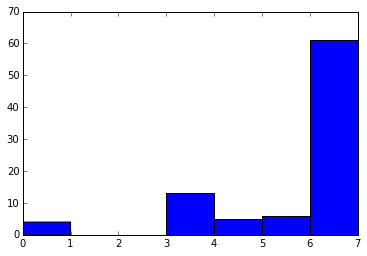

In [17]:
predicted_vine = np.argmax(vinePy_x, axis=1)
plt.hist(predicted_vine, bins=[0, 1, 2, 3,4 ,5 ,6 , 7])

5


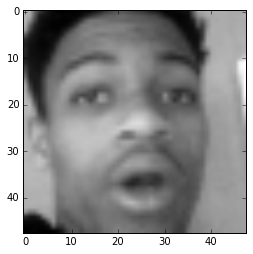

In [19]:
plt.imshow(videoFaces[10][0][:][:], cmap = cm.Greys_r)
print predicted_vine[10]

(89, 7)
(89,)
0.701448


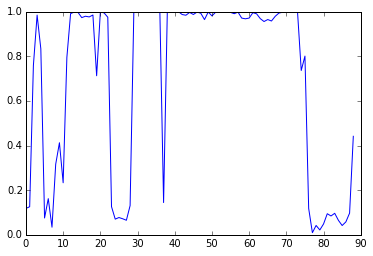

In [20]:
print vinePy_x.shape
a = vinePy_x[:,6]
print a.shape
plt.plot(a)
print np.mean(a)

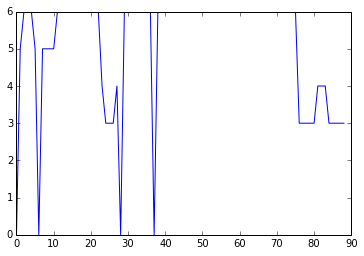

In [21]:
emos = np.argmax(vinePy_x , axis = 1)
plt.plot(emos)

In [22]:
errorVal = np.mean(np.argmax(ValY, axis=1) == predict(ValX))
error = np.mean(np.argmax(teY, axis=1) == predict(teX))
print error
print errorVal

# prediction = predict(teX)
# print prediction.shape
# print np.argmax(teY , axis=1)

0.638060741154
0.559633027523


In [23]:
predicted = predict(ValX)
real = np.argmax(ValY, axis=1)
confusion = np.zeros((7,7))
for i in range(0 , len(real)):
    j = real[i]
    k = predicted[i]
    #print "Real:  %d , predicted %d"%(j,k)
    confusion[j][k] = confusion[j][k] + 1
print confusion

[[ 14.   0.   2.   0.  14.   0.  15.]
 [ 38.   6.   1.   5.  11.   0.  16.]
 [  0.   3.   3.   6.   5.   2.   6.]
 [  1.   0.   0.  68.   0.   0.   0.]
 [  4.   1.   3.   0.  15.   1.   4.]
 [  1.   0.   0.   1.   3.  77.   1.]
 [  0.   0.   0.   0.   0.   0.   0.]]


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [24]:
print MSFTPredict.shape

(3589, 7)


In [25]:
py_val = probpredict(teX)

In [26]:
py_test = probpredict(ValX)

In [27]:
print py_val.shape

(3589, 7)


Train Bayesian classifier here

In [28]:
compound_result = np.concatenate((py_val,MSFTPredict ), axis=1)
print compound_result.shape
error_compound = np.mean(np.argmax(teY, axis=1) == (np.argmax(compound_result, axis=1)%7) )
print error_compound

(3589, 14)
0.655335748119


In [31]:
compound_test = np.concatenate((py_test,MSFTPredictCK ), axis=1)
print compound_test.shape
error_test = np.mean(np.argmax(ValY, axis=1) == (np.argmax(compound_test, axis=1)%7) )
print error_test

(327, 14)
0.608562691131


In [32]:
from sklearn.naive_bayes import GaussianNB

In [33]:
clf = GaussianNB()
labels = np.argmax(teY, axis=1)
compound_result[compound_result < 0] = 0
clf.fit(compound_result, labels)

GaussianNB()

In [34]:
bayesian_predict = clf.predict(compound_test)
print bayesian_predict.shape

(327,)


In [35]:
error_bayesian = np.mean(np.argmax(ValY, axis=1) == bayesian_predict )
print error_bayesian

0.755351681957


In [36]:
ans = np.argmax(ValY, axis=1)
confusion = np.zeros((7,7))
for i in range(0 , len(bayesian_predict)):
    j = bayesian_predict[i]
    k = ans[i]
    #print "Real:  %d , predicted %d"%(j,k)
    confusion[j][k] = confusion[j][k] + 1
print confusion

[[ 18.   1.   3.   1.   1.   1.   0.]
 [  2.  55.   4.   0.   2.   0.   0.]
 [  1.   0.   8.   0.   1.   1.   0.]
 [  0.   7.   3.  68.   0.   0.   0.]
 [  5.   1.   5.   0.  18.   0.   0.]
 [  0.   0.   1.   0.   0.  80.   0.]
 [ 19.  13.   1.   0.   6.   1.   0.]]


In [37]:
print "Precision: "
for j in range(0,7):
    print (confusion[j][j]/sum(confusion[:][j]))

print "true negatives : "
for j in range(0,7):
    print (sum(confusion[j][:]) - confusion[j][j])/sum(confusion[j][:])

Precision: 
0.72
0.873015873016
0.727272727273
0.871794871795
0.620689655172
0.987654320988
0.0
true negatives : 
0.28
0.126984126984
0.272727272727
0.128205128205
0.379310344828
0.0123456790123
1.0


In [39]:
lists = []
infile = open('../Logs/ErrosCNN7LayersV2.pickle', 'r')
while 1:
    try:
        lists.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

In [40]:
errors = np.zeros((len(lists),))
cost = np.zeros((len(lists),))
for i in range(len(lists)):
    log = lists[i].split(' ')
    errors[i] = float(log[4])
    cost[i] = float(log[6])
    

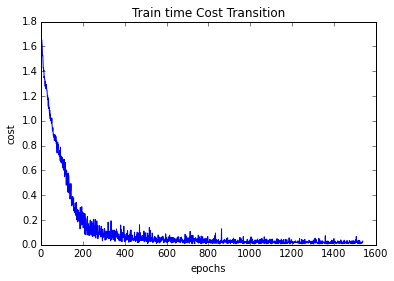

In [41]:
plt.plot(cost)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Train time Cost Transition')
plt.show()
plt.savefig('cost')

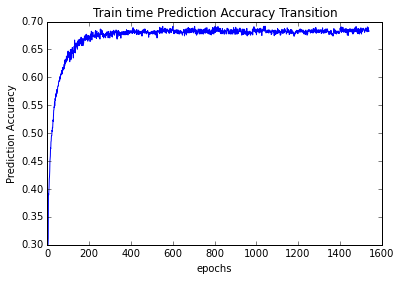

In [42]:
plt.plot(errors)
plt.ylabel('Prediction Accuracy')
plt.xlabel('epochs')
plt.title('Train time Prediction Accuracy Transition')
plt.show()
plt.savefig('prediction_accuracy')

In [43]:
A = Params[0].get_value()

In [44]:
A = A.reshape(64,1*7*7)

In [45]:
image = T.flatten(Params[0], outdim=2)
print image.shape

Shape.0


In [46]:
print A.shape

(64, 49)


In [47]:
from utils import tile_raster_images

In [48]:
filters = tile_raster_images(A ,(7,7) , (7,7) ,(3,3) )

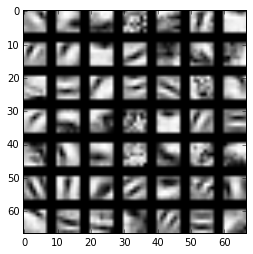

In [49]:
plt.imshow(filters,cmap = cm.Greys_r)